Refering to  Mark Minervini’s Trend Template, I implemented the following trend following strategy, whitch is to long 20 stocks based on the following condition:


1.close price > 50-day Exponential moving average

2.50-day ema >  both 150-day ema and 200-day ema

3.150-day ema > 200-day ema

4.close price > 150-day ema and 200-day ema



When the number of stock satisfied the condition>20, rank them by Relative Price Strength Rating(RS) in the past 60 days window.

All stocks have equal weight

stop loss signal set to 20%

transaction cost = 0.1%

rebalance period = 20 days




In [38]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Data Processing
data  = pd.read_csv('data.csv')
data_id = data.set_index(['ticker','date'])
data_last = data_id['last'].unstack().transpose()
data_volume = data_id['volume'].unstack().transpose()

In [39]:
def filter_stock(close:pd.Series) -> bool:
    lookback_short = 20 #lookback emw 
    lookback_mid = 60
    lookback_long = 150

    ema_50 = ta.ema(close,lookback_short).iloc[-1]
    ema_150 = ta.ema(close,lookback_mid).iloc[-1]
    ema_200 = ta.ema(close,min(lookback_long,len(close))).iloc[-1]

    ema_200_smooth = ta.ema(ta.ema(close,min(lookback_long,len(close))),20).iloc[-1]
    high_52week = close.rolling(52*5).max().iloc[-1]
    low_52week = close.rolling(52*5).min().iloc[-1]

    cl = close.iloc[-1] # close price

    # filter1: close price > 150-day ewma and 200-day ewma
    if cl > ema_150 and cl > ema_200:
        condition_1 = True
    else:
        condition_1 = False

    # filter2：150-day ewma > 200-day ewma
    if ema_150 > ema_200:
        condition_2 = True
    else:
        condition_2 = False

    #filter 3: 200-day ewma has grown for a month
    if ema_200 > ema_200_smooth:
        condition_3 = True
    else:
        condition_3 = False

    # filter 4: 50-day ewma >  both 150-day ewma and 200-day ewma
    if ema_50 > ema_150 and ema_50 > ema_200:
        condition_4 = True
    else:
        condition_4 = False

    # filter5: close price > 50-day ewma
    if cl > ema_50:
        condition_5 = True
    else:
        condition_5 = False

    # filter 6: close price is 30% higher than the 52-week lowest price
    if cl >= low_52week * 1.3:
        condition_6 = True
    else:
        condition_6 = False

    # filter7: close price is within 25% of the 52-week highest price
    if cl >= high_52week * 0.75 and cl <= high_52week * 1.25:
        condition_7 = True
    else:
        condition_7 = False

    
    # if (condition_1 and condition_2 and condition_3 and
    #     condition_4 and condition_5 ):
        
    if (condition_5 and condition_4 and condition_2 and condition_1):
        meet_criterion = True
    else:
        meet_criterion = False

    return meet_criterion


In [49]:
rebalance = 20
lookback_short = 50 #lookback emw 
lookback_mid = 100
lookback_long = 150
lookback_rs = 60
initial_budget = 1000000
n_stocks = 20
trading_cost = 1.0/1000
stop_loss = -0.2

net_value = pd.DataFrame([0]*data_last.shape[0], index=data_last.index, columns=['net_value'])
cash = pd.DataFrame([0]*data_last.shape[0], index=data_last.index,columns=['cash'])
# Target Weight
weight = pd.DataFrame(np.zeros(shape=data_last.shape),columns=data_last.columns, index=data_last.index)
# stock Position
stock_pos = pd.DataFrame(np.zeros(shape=data_last.shape),columns=data_last.columns, index=data_last.index)
basket = pd.DataFrame([0]*data_last.shape[0], index=data_last.index, columns=['num_of_stock'])


In [50]:
# initialize first lookback period
for i in range(0,lookback_long):
    cash.iloc[i] = initial_budget
    net_value.iloc[i] = initial_budget

idx_pre = idx_buy = data_last.columns

for i in range(lookback_long, data_last.shape[0]):

    today_price = data_last.iloc[i-1:i+1]
    today_ret = (today_price - today_price.shift()).iloc[1:]/today_price.shift().iloc[1]
    today_ret = today_ret.fillna(0)
    
    if i > lookback_long:
        portfolio_ret = (stock_pos.iloc[i-1][idx_pre]*(today_ret[idx_pre]+1)).sum().sum()/stock_pos.iloc[i-1][idx_pre].sum()-1

    else: 
        portfolio_ret = 1
    # stock_pos.iloc[i][idx_pre] = stock_pos.iloc[i-1][idx_pre]*(today_ret[idx_pre]+1)
    # portfolio_ret = stock_pos.iloc[i][idx_pre].sum()/stock_pos.iloc[i-1][idx_pre].sum()-1

    #rebalance 
    if (i - lookback_long) % rebalance == 0 or portfolio_ret < stop_loss:
        temp = data_last.iloc[i-lookback_long : i-1].dropna(axis=1)
        temp_ret = (np.log(temp)).diff()[1:]

        idx_buy = temp.apply(filter_stock,axis = 0)
        idx_buy = idx_buy[idx_buy==True].index

        if (len(idx_buy) >= n_stocks): # use rs rank to select top 20 stocks , lookback period is 90 days
            
            temp_ret_90 = temp_ret[len(temp_ret)-90: ].sum(axis = 0)
            idx_buy = temp_ret_90.nlargest(n_stocks).index
            weight.iloc[i][idx_buy] = 1.0/n_stocks
            basket.iloc[i] = n_stocks

        elif len(idx_buy)==0:  # no stock satisfy
            basket.iloc[i] = len(idx_buy)
        else:
            weight.iloc[i][idx_buy] = 1.0/len(idx_buy)
            basket.iloc[i] = len(idx_buy)
            
        if i > lookback_long:
            # rebalance, sell stock not picked this time
            cash.iloc[i] = stock_pos.iloc[i-1][idx_pre].sum()*(1-trading_cost)+cash.iloc[i-1]
        else: # i is start date
            cash.iloc[i] = cash.iloc[i-1]

        available_cash = cash.iloc[i].values[0]


        # rebalance, at the end of date i-1 determine the weight[i]
        for stock_id in idx_buy:
            target_pos = weight.iloc[i][stock_id]*available_cash
            # stock is not perfectly divisible
            n_temp = np.floor(target_pos/(data_last.iloc[i-1][stock_id]*(1+trading_cost))) # at end of date i-1
            stock_pos.iloc[i][stock_id] = n_temp*data_last.iloc[i-1][stock_id] # at beginning of date i

            cash.iloc[i] -= n_temp*data_last.iloc[i-1][stock_id]*(1+trading_cost)
        stock_pos.iloc[i] = stock_pos.iloc[i] *(today_ret[stock_pos.columns]+1) # at the end of date i
        idx_pre = idx_buy

    # not at rebalance date    
    else:
        basket.iloc[i] =  basket.iloc[i-1]
        weight.iloc[i] = weight.iloc[i-1]
        stock_pos.iloc[i] = stock_pos.iloc[i-1]*(today_ret[stock_pos.columns]+1)
        cash.iloc[i] = cash.iloc[i-1]
    net_value.iloc[i] = cash.iloc[i] + sum(stock_pos.iloc[i])

C:\Users\wenyu\AppData\Local\Temp/ipykernel_119560/1569614810.py:15: RuntimeWarning: invalid value encountered in double_scalars
  portfolio_ret = (stock_pos.iloc[i-1][idx_pre]*(today_ret[idx_pre]+1)).sum().sum()/stock_pos.iloc[i-1][idx_pre].sum()-1


In [51]:
ret = np.log(net_value).diff().dropna()
annual_ret = ret.mean().values[0]*252
annual_vol = ret.std().values[0]*np.sqrt(252)
sharpe = annual_ret/annual_vol
s=(ret+1).cumprod()
mdd_pct = (1-np.ptp(s)/s.max()).values[0]
mdd_usd = (net_value.cummax()-net_value).max()
mdd_usd = mdd_usd.values[0]
r_d = ret[ret<0].dropna()
down_deviation = np.sqrt(252)*(np.sqrt((0 - r_d)**2).sum())/r_d.shape[0]
down_deviation = down_deviation.values[0]
sortino = annual_ret/ down_deviation

print("Annualized Return: ", annual_ret*100, "%")
print("Annualized Volatility: ", annual_vol*100, "%")
print("Downside Deviation: ", down_deviation*100, "%")
print("Max Drawdown(in percentage): ", mdd_pct*100, "%")
print("Max Drawdown(in dollars): ", mdd_usd)
print("Sharpe Ratio: ", sharpe)
print("Sortino Ratio: ", sortino)



Annualized Return:  6.426808640694144 %
Annualized Volatility:  20.083822788436148 %
Downside Deviation:  16.030314488845328 %
Max Drawdown(in percentage):  47.36039153783984 %
Max Drawdown(in dollars):  1001488.090643598
Sharpe Ratio:  0.31999927047726034
Sortino Ratio:  0.40091594242684575


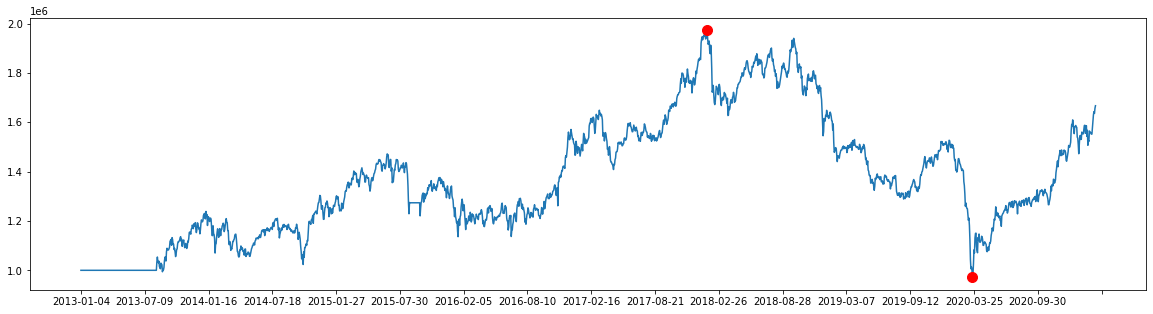

In [52]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
i = np.argmax(np.maximum.accumulate(net_value) - net_value) # end of the period
j = np.argmax(net_value[:i]) # start of period
ax.plot(net_value)
ax.plot([net_value.index[i], net_value.index[j]], [net_value.iloc[i], net_value.iloc[j]], 'o', color='Red', markersize=10)
tick_space = 126
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_space))
plt.show()

#### Analysis

The startegy works bad mainly because there aren't enough stocks satisfying the condition (originally I give more conditions but no stocks meet the criteria so I relax a few).This shows the strategy does not fit this stock basket well. And the maximum drawdown happens in the covid-19 when the whole market works bad. Due to the time limit I did not consider the short selling and usage of volume data. If there are more information like financial-report data, this strategy may improve.